# OpenEO endpoint in Examind - Example - Python Client

By Quentin BIALOTA (Geomatys)

Contact : quentin.bialota@geomatys.com

---

### **/!\ WARNING**
This initial implementation of openEO may contain bugs. Please let me know if you find any.

In this tutorial we will use the python client to create and execute openEO processes on Examind.

---

**Prerequisites :**
- Have an examind (via docker) running on your machine
- Have imported sentinel-2 data in Examind (through the web ui http://localhost/8080/examind [login: admin / password: admin])
- In examind, have created a WCS (in Web Services page) named `test` (with the sentinel-2 data you imported)
- In examind, have created a WPS (in Web Services page) named `test` (you need to enable Versions `1.0.0` **AND** `2.0.0`)
- In the docker compose, have added the following environment variables to the examind service :
  ```yml
    environment:
      EXAMIND_ENABLE_BASIC_AUTH: "true" # To be able to authenticate on openEO endpoints
      EXAMIND_ENABLE_PARAM_TOKEN: "true" # To be able to authenticate on openEO endpoints
      EXAMIND_WPS_EXECUTE_SECURE: "true" # To enable the safety check when executing WPS processes via openEO
  ```

In [65]:
import openeo as eo
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from matplotlib.colors import LinearSegmentedColormap

SERVER_URL = "http://localhost:8080/examind/WS/openeo/test"
LOGIN = "admin"
PASSWORD = "admin"

### 1 - Connection to the server

In [47]:
connection = eo.connect(SERVER_URL)

print("Authenticate with Basic authentication")
connection.authenticate_basic(LOGIN, PASSWORD)

print(connection)

Authenticate with Basic authentication
<Connection to 'http://localhost:8080/examind/WS/openeo/test/' with BasicBearerAuth>


In [16]:
connection.describe_collection("1")

{'stac_version': '1.0.0',
 'stac_extensions': [],
 'type': 'Collection',
 'keywords': [],
 'cube:dimensions': {'x': {'axis': 'x',
   'extent': [3.8534545898437504, 4.577865600585938],
   'values': None,
   'step': '5.795288085937504E-4',
   'unit': 'degree',
   'reference_system': '84',
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [43.5408336643793, 43.862257524417934],
   'values': None,
   'step': '4.190663103502415E-4',
   'unit': 'degree',
   'reference_system': '84',
   'type': 'spatial'},
  'bands': {'values': ['0', '1', '2', '3', '4', '5'], 'type': 'bands'}},
 'deprecated': False,
 'license': 'no licence specified',
 'summaries': {'bands': [{'unit': 'no unit',
    'name': '0',
    'description': 'Grayscale'},
   {'unit': 'no unit', 'name': '1', 'description': 'Grayscale'},
   {'unit': 'no unit', 'name': '2', 'description': 'Grayscale'},
   {'unit': 'no unit', 'name': '3', 'description': 'Grayscale'},
   {'unit': 'no unit', 'name': '4', 'description': 'Grayscale'},
   {'unit': 'no unit', 'name': '5', 'description': 'Grayscale'}]},
 'providers': None,
 'id': '1',
 'title': '1',
 'name': '1',
 'links': [{'href': 'http://localhost:8080/examind/WS/coverage/test/collections/1/coverage',
   'rel': 'items',
   'type': 'image/tiff',
   'hreflang': 'en',
   'title': '1'},
  {'href': 'http://localhost:8080/examind/WS/coverage/test/collections/1/coverage?f=image/tiff',
   'rel': 'items',
   'type': 'image/tiff',
   'hreflang': 'en',
   'title': '1'},
  {'href': 'http://localhost:8080/examind/WS/coverage/test/collections/1/coverage?f=application/x-netcdf',
   'rel': 'items',
   'type': 'application/x-netcdf',
   'hreflang': 'en',
   'title': '1'}],
 'itemType': 'feature',
 'crs': ['http://www.opengis.net/def/crs/OGC/1.3/CRS84'],
 'storageCrs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84',
 'extent': {'spatial': {'bbox': [[3.8534545898437504,
     43.5408336643793,
     4.577865600585938,
     43.862257524417934]],
   'storageCrsBbox': None,
   'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84',
   'grid': []},
  'srs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'}}

## Create a process
### Method 1 - Step by step process creation

For this first method we will use directly the functions exposed by the python client.

For the save result you can either :
- Add the `save_result` process with `datacube.save_result(format="GTIFF")` (then `datacube.execute()` for json output or `datacube.download()` for other formats (like GeoTiff))
- Or you can run directly the `datacube.download(format="GTIFF")` function (it will add automatically the `save_result` and execute the graph)

**Method 1 : Apply a specific process by its id `save_result` (then `execute`)**

In [60]:
def createDataCube():
    datacube = connection.load_collection(
        "1",
        spatial_extent={"west": 3.87, "south": 43.56, "east": 4.5, "north": 43.85},
        bands=[0,2,4]
    )
    return datacube
createDataCube()

**Method 1 : Use `datacube.save_result(format="GTIFF")` (then `databue.execute()`)**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5843].


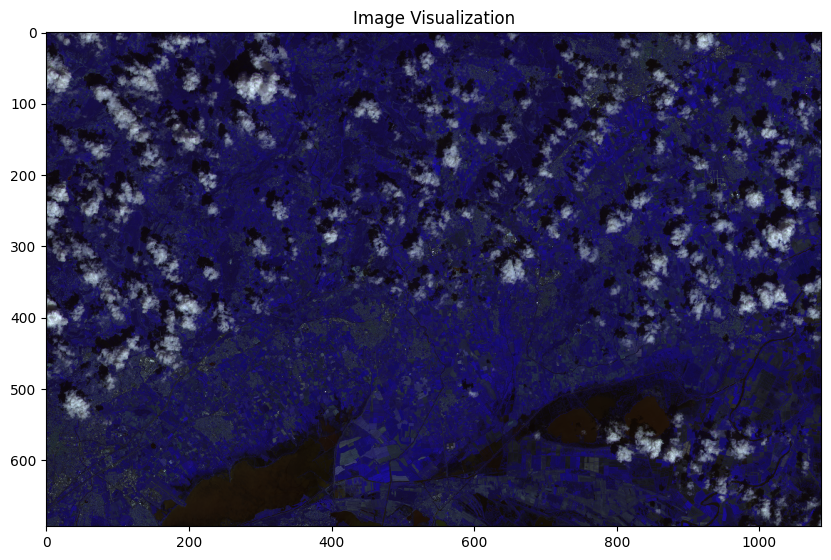

In [72]:
datacube = createDataCube()
datacube.save_result(format="GTIFF")
result = datacube.download()

with BytesIO(result) as memfile:
    with rasterio.open(memfile) as src:
        RED = src.read(1)
        BLUE = src.read(2)
        NIR = src.read(3)

        # Stack bands and transpose to (height, width, channels)
        rgb = np.dstack((RED, BLUE, NIR))

# The result will be weird but it shows the result image with three bands
plt.figure(figsize=(10, 8))
plt.imshow(rgb)
plt.title("Image Visualization")
plt.show()

Here is the result with `execute()` instead of `download()`

In [64]:
datacube.execute()

{'gridGeometry': {'extent': {'low': {'coordinateValues': [29, 29],
    'dimension': 2},
   'high': {'coordinateValues': [1115, 721], 'dimension': 2},
   'sliceCoordinates': {},
   'dimension': 2},
  'envelope': {'empty': False,
   'coordinateReferenceSystem': {'name': {'authority': None,
     'code': 'WGS 84',
     'codeSpace': None,
     'version': None,
     'description': None,
     'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [{'parsedNames': [

**Method 2 : Run the `datacube.download(format="GTIFF")` function (it will add automatically the `save_result` and execute the graph)**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5843].


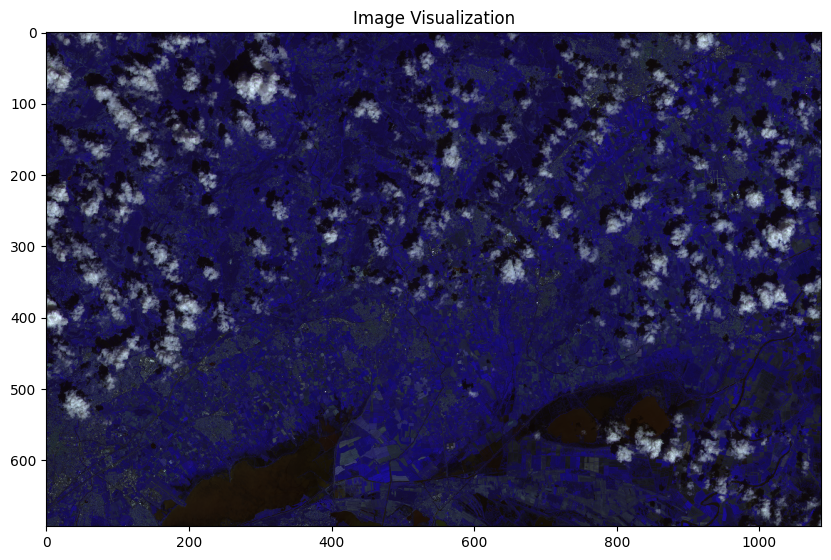

In [71]:
datacube = createDataCube()
result = datacube.download(format="GTIFF")

with BytesIO(result) as memfile:
    with rasterio.open(memfile) as src:
        RED = src.read(1)
        BLUE = src.read(2)
        NIR = src.read(3)

        # Stack bands and transpose to (height, width, channels)
        rgb = np.dstack((RED, BLUE, NIR))

# The result will be weird but it shows the result image with three bands
plt.figure(figsize=(10, 8))
plt.imshow(rgb)
plt.title("Image Visualization")
plt.show()

**A more complex process**

EVI Calculation

In [33]:
datacube = connection.load_collection(
    "1",
    spatial_extent={"west": 3.87, "south": 43.56, "east": 4.5, "north": 43.85},
    bands=[0,2,4]
)

# Band selection
red = datacube.process("geotoolkit.coverage:bandselect", coverage=datacube, bands=[0])
blue = datacube.process("geotoolkit.coverage:bandselect", coverage=datacube, bands=[1])
nir = datacube.process("geotoolkit.coverage:bandselect", coverage=datacube, bands=[2])

# Multiply bands with factors
red_x6 = red.process("geotoolkit.coverage:math:multiplyWithValue", coverage=red, value=6.0)
blue_x7_5 = datacube.process("geotoolkit.coverage:math:multiplyWithValue", coverage=blue, value=7.5)

# Subtract NIR - RED
nir_minus_red = datacube.process("geotoolkit.coverage:math:substract", first=nir, second=red)

# Add NIR + (6*RED)
nir_plus_red_x6 = datacube.process("geotoolkit.coverage:math:sum", first=nir, second=red_x6)

# Add [NIR + 6*RED] + [7.5*BLUE]
nir_plus_red_x6_plus_blue_x7_5 = datacube.process(
    "geotoolkit.coverage:math:sum",
    first=nir_plus_red_x6,
    second=blue_x7_5
)

# Add [NIR + 6*RED + 7.5*BLUE] + 1
denominator = datacube.process(
    "geotoolkit.coverage:math:sumWithValue",
    coverage=nir_plus_red_x6_plus_blue_x7_5,
    value=1.0
)

# Divide numerator / denominator
evi_raw = datacube.process(
    "geotoolkit.coverage:math:divide",
    first=nir_minus_red,
    second=denominator
)

# Multiply result by 2.5
evi = datacube.process(
    "geotoolkit.coverage:math:multiplyWithValue",
    coverage=evi_raw,
    value=2.5
)

EVI_GRAPH = evi.save_result("GTIFF")
EVI_GRAPH

In [35]:
result = EVI_GRAPH.download()

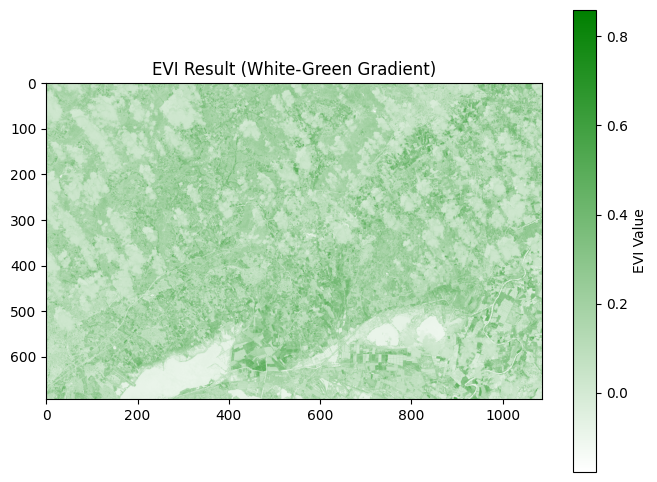

In [36]:
with BytesIO(result) as memfile:
    with rasterio.open(memfile) as src:
        arr = src.read(1)

# Create a custom white-to-green colormap
white_green = LinearSegmentedColormap.from_list('white_green', ['white', 'green'])

plt.figure(figsize=(8, 6))
plt.imshow(arr, cmap=white_green)
plt.title("EVI Result (White-Green Gradient)")
plt.colorbar(label="EVI Value")
plt.show()

### Method 2 - Define the full process graph

In [33]:
process_graph = {
    "id": "test-execution",
    "summary": "Enhanced Vegetation Index",
    "description": "Computes the Enhanced Vegetation Index (EVI). It is computed with the following formula: `2.5 * (NIR - RED) / (1 + NIR + 6*RED + -7.5*BLUE)`.",
    "parameters": [],
    "returns": {
        "description": "Computed EVI.",
        "schema": {
            "type": "object"
        }
    },
    "process_graph": {
        "1": {
            "process_id": "geotoolkit.coverage:math:substract",
            "arguments": {
                "first": {
                    "from_node": "geotoolkit3"
                },
                "second": {
                    "from_node": "geotoolkit1"
                }
            }
        },
        "2": {
            "process_id": "geotoolkit.coverage:math:multiplyWithValue",
            "arguments": {
                "coverage": {
                    "from_node": "geotoolkit1"
                },
                "value": 6.0
            }
        },
        "3": {
            "process_id": "geotoolkit.coverage:math:multiplyWithValue",
            "arguments": {
                "coverage": {
                    "from_node": "geotoolkit2"
                },
                "value": 7.5
            }
        },
        "load1": {
            "process_id": "load_collection",
            "arguments": {
                "id": "sentinel_evi_bands",
                "spatial_extent": {
                    "west": 3.87,
                    "east": 4.5,
                    "north": 43.85,
                    "south": 43.56,
                    "crs": "urn:ogc:def:crs:OGC:1.3:CRS84"
                },
                "bands": [
                    0,
                    2,
                    4
                ]
            }
        },
        "geotoolkit1": {
            "process_id": "geotoolkit.coverage:bandselect",
            "arguments": {
                "coverage": {
                    "from_node": "load1"
                },
                "bands": [
                    0
                ]
            }
        },
        "geotoolkit2": {
            "process_id": "geotoolkit.coverage:bandselect",
            "arguments": {
                "coverage": {
                    "from_node": "load1"
                },
                "bands": [
                    1
                ]
            }
        },
        "geotoolkit3": {
            "process_id": "geotoolkit.coverage:bandselect",
            "arguments": {
                "coverage": {
                    "from_node": "load1"
                },
                "bands": [
                    2
                ]
            }
        },
        "geotoolkit4": {
            "process_id": "geotoolkit.coverage:math:sum",
            "arguments": {
                "first": {
                    "from_node": "geotoolkit3"
                },
                "second": {
                    "from_node": "2"
                }
            }
        },
        "geotoolkit5": {
            "process_id": "geotoolkit.coverage:math:sum",
            "arguments": {
                "first": {
                    "from_node": "geotoolkit4"
                },
                "second": {
                    "from_node": "3"
                }
            }
        },
        "geotoolkit7": {
            "process_id": "geotoolkit.coverage:math:sumWithValue",
            "arguments": {
                "coverage": {
                    "from_node": "geotoolkit5"
                },
                "value": 1.0
            }
        },
        "geotoolkit8": {
            "process_id": "geotoolkit.coverage:math:divide",
            "arguments": {
                "second": {
                    "from_node": "geotoolkit7"
                },
                "first": {
                    "from_node": "1"
                }
            }
        },
        "geotoolkit9": {
            "process_id": "geotoolkit.coverage:math:multiplyWithValue",
            "arguments": {
                "coverage": {
                    "from_node": "geotoolkit8"
                },
                "value": 2.5
            }
        },
        "save10": {
            "process_id": "save_result",
            "arguments": {
                "data": {
                    "from_node": "geotoolkit9"
                },
                "format": "GTIFF"
            },
            "result": "true"
        }
    },
    "parameters": []
}

**You can run this process graph via a sync request**

In [ ]:
result = connection.download(process_graph)

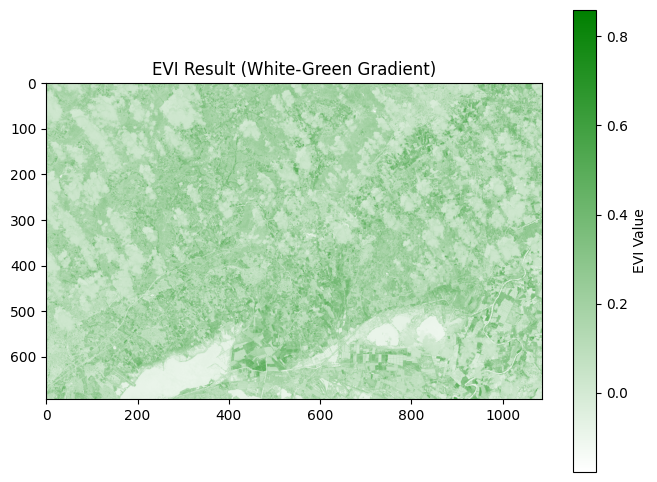

In [48]:
with BytesIO(result) as memfile:
    with rasterio.open(memfile) as src:
        arr = src.read(1)

# Create a custom white-to-green colormap
white_green = LinearSegmentedColormap.from_list('white_green', ['white', 'green'])

plt.figure(figsize=(8, 6))
plt.imshow(arr, cmap=white_green)
plt.title("EVI Result (White-Green Gradient)")
plt.colorbar(label="EVI Value")
plt.show()

**Or you can also create a process and execute it later via the "jobs" endpoint**

In [69]:
connection.create_job(process_graph)
# /!\ WARNING /!\
# For the moment the job creation return an error but the job is created on the server side

OpenEoClientException: Job creation response did not contain a valid job id

In [70]:
connection.list_jobs()

[{'id': '91a977b7-ea62-42fd-a6f5-852b1e28789b',
  'status': 'created',
  'created': '2025-10-27T15:41:28',
  'process': {'id': 'test-execution-6421a59d-8a41-4fd8-a5db-6724fcde3bb7',
   'summary': 'Enhanced Vegetation Index',
   'description': 'Computes the Enhanced Vegetation Index (EVI). It is computed with the following formula: `2.5 * (NIR - RED) / (1 + NIR + 6*RED + -7.5*BLUE)`.',
   'categories': [],
   'parameters': [],
   'returns': {'description': 'Computed EVI.', 'schema': {'type': ['OBJECT']}},
   'deprecated': False,
   'experimental': False,
   'exceptions': {},
   'examples': [],
   'links': [],
   'process_graph': {'load1': {'process_id': 'load_collection',
     'title': None,
     'description': None,
     'arguments': {'spatial_extent': {'value': {'west': 3.87,
        'south': 43.56,
        'east': 4.5,
        'north': 43.85,
        'base': 0.0,
        'height': 0.0,
        'crs': 'urn:ogc:def:crs:OGC:1.3:CRS84'},
       'type': 'VALUE'},
      'id': {'value': 'sentinel_evi_bands', 'type': 'VALUE'},
      'bands': {'value': [{'value': 0, 'type': 'VALUE'},
        {'value': 2, 'type': 'VALUE'},
        {'value': 4, 'type': 'VALUE'}],
       'type': 'ARRAY'}},
     'returns': None,
     'result': False},
    'geotoolkit3': {'process_id': 'geotoolkit.coverage:bandselect',
     'title': None,
     'description': None,
     'arguments': {'coverage': {'value': 'load1', 'type': 'FROM_NODE'},
      'bands': {'value': [{'value': 2, 'type': 'VALUE'}], 'type': 'ARRAY'}},
     'returns': None,
     'result': False},
    'geotoolkit2': {'process_id': 'geotoolkit.coverage:bandselect',
     'title': None,
     'description': None,
     'arguments': {'coverage': {'value': 'load1', 'type': 'FROM_NODE'},
      'bands': {'value': [{'value': 1, 'type': 'VALUE'}], 'type': 'ARRAY'}},
     'returns': None,
     'result': False},
    'geotoolkit1': {'process_id': 'geotoolkit.coverage:bandselect',
     'title': None,
     'description': None,
     'arguments': {'coverage': {'value': 'load1', 'type': 'FROM_NODE'},
      'bands': {'value': [{'value': 0, 'type': 'VALUE'}], 'type': 'ARRAY'}},
     'returns': None,
     'result': False},
    '3': {'process_id': 'geotoolkit.coverage:math:multiplyWithValue',
     'title': None,
     'description': None,
     'arguments': {'coverage': {'value': 'geotoolkit2', 'type': 'FROM_NODE'},
      'value': {'value': 7.5, 'type': 'VALUE'}},
     'returns': None,
     'result': False},
    '1': {'process_id': 'geotoolkit.coverage:math:substract',
     'title': None,
     'description': None,
     'arguments': {'first': {'value': 'geotoolkit3', 'type': 'FROM_NODE'},
      'second': {'value': 'geotoolkit1', 'type': 'FROM_NODE'}},
     'returns': None,
     'result': False},
    '2': {'process_id': 'geotoolkit.coverage:math:multiplyWithValue',
     'title': None,
     'description': None,
     'arguments': {'coverage': {'value': 'geotoolkit1', 'type': 'FROM_NODE'},
      'value': {'value': 6.0, 'type': 'VALUE'}},
     'returns': None,
     'result': False},
    'geotoolkit4': {'process_id': 'geotoolkit.coverage:math:sum',
     'title': None,
     'description': None,
     'arguments': {'first': {'value': 'geotoolkit3', 'type': 'FROM_NODE'},
      'second': {'value': '2', 'type': 'FROM_NODE'}},
     'returns': None,
     'result': False},
    'geotoolkit5': {'process_id': 'geotoolkit.coverage:math:sum',
     'title': None,
     'description': None,
     'arguments': {'first': {'value': 'geotoolkit4', 'type': 'FROM_NODE'},
      'second': {'value': '3', 'type': 'FROM_NODE'}},
     'returns': None,
     'result': False},
    'geotoolkit7': {'process_id': 'geotoolkit.coverage:math:sumWithValue',
     'title': None,
     'description': None,
     'arguments': {'coverage': {'value': 'geotoolkit5', 'type': 'FROM_NODE'},
      'value': {'value': 1.0, 'type': 'VALUE'}},
     'returns': None,
     'result': False},
    'geotoolkit8': {'process_id': 'geotoolkit.coverage:math:divide',
     'title': None,
     'desc

In [72]:
job = connection.job("91a977b7-ea62-42fd-a6f5-852b1e28789b")

In [73]:
job.start_and_wait()

0:00:00 Job '91a977b7-ea62-42fd-a6f5-852b1e28789b': send 'start'
0:00:00 Job '91a977b7-ea62-42fd-a6f5-852b1e28789b': created (progress 0.0%)
0:00:05 Job '91a977b7-ea62-42fd-a6f5-852b1e28789b': finished (progress 100.0%)


<BatchJob job_id='91a977b7-ea62-42fd-a6f5-852b1e28789b'>

In [74]:
job.get_results()

<JobResults for job '91a977b7-ea62-42fd-a6f5-852b1e28789b'>

In [79]:
result_file = job.get_results().download_file()

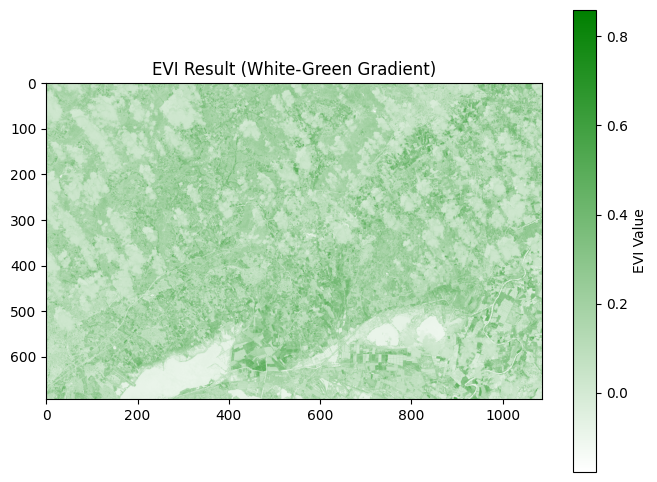

In [82]:
with rasterio.open(result_file) as src:
    arr = src.read(1)
# Create a custom white-to-green colormap
white_green = LinearSegmentedColormap.from_list('white_green', ['white', 'green'])

plt.figure(figsize=(8, 6))
plt.imshow(arr, cmap=white_green)
plt.title("EVI Result (White-Green Gradient)")
plt.colorbar(label="EVI Value")
plt.show()